# SMCNOD
This notebook presents the mixture model of 3 gaussians built for SMCNOD data. The data is taken from the S5 Collaboration. With quality cut, we obtained 371 stars with good measurements to feed the model. The mixture model is built with 16 parameters, including radial velocity, metallicity and proper motion parameters of the smcnod and a set of parameters for the background components. We fit a Gaussian mixture model to this data using `emcee`.

In [2]:
# Imports
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize, stats
from astropy.table import Table
import emcee
import corner
from collections import OrderedDict
import time
from astropy import table 
from astropy.io import ascii
import astropy.io.fits as fits
from astropy.coordinates import SkyCoord
from scipy.signal import find_peaks
import uncertainties.umath as um
from uncertainties import ufloat
import imp

## SMCNOD Data

In [3]:
# Load fits file
with fits.open('s5dr32_gdr3.fits') as hdu_list:
    table_S5 = table.Table(hdu_list[1].data)
table_S5
# SMC Centre
RA_smc, DEC_smc = 13, -72.817
alpha_smc = np.radians(RA_smc)
delta_smc = np.radians(DEC_smc)
# SMCNOD Centre
RA, DEC = 12, -64.8 # deg
alpha1 = np.radians(RA)
delta1 = np.radians(DEC)
alpha2 = np.radians(table_S5['ra'])
delta2 = np.radians(table_S5['dec'])
angular_sep_rad = np.arccos(np.sin(delta1) * np.sin(delta2) + \
                            np.cos(delta1) * np.cos(delta2) * np.cos(alpha1 - alpha2))
# Radius cut
cut_r = 1.05 # deg
sel_radius = np.degrees(angular_sep_rad) < cut_r
table_cut = table_S5[sel_radius]
# Quality cut
c1 = table_cut['best_sn_1700d'] > 4
c2 = table_cut['best_sn_580v'] > 4
c3 = table_cut['good_star_pb'] > 0.5
c4 = table_cut['vel_calib_std'] < 10
c5 = table_cut["feh_calib_std"] < 0.5
c6 = np.sqrt(table_cut['pmra']**2 + table_cut['pmdec']**2) < 10
high_quality = (c1 | c2) & c3 & c4 & c6
table_cut = table_cut[high_quality]
tab = table_cut

In [4]:
len(tab)

291

In [5]:
# heliocentric radial velocity
rv = tab["vel_calib"]
rverr = tab["vel_calib_std"]
# metallicity
feh = tab["feh50"]
feherr = tab["feh_calib_std"]
# proper motions
pmra = tab["pmra"]
pmraerr = tab["pmra_error"]
pmdec = tab["pmdec"]
pmdecerr = tab["pmdec_error"]

Text(0.5, 0, 'pmdec')

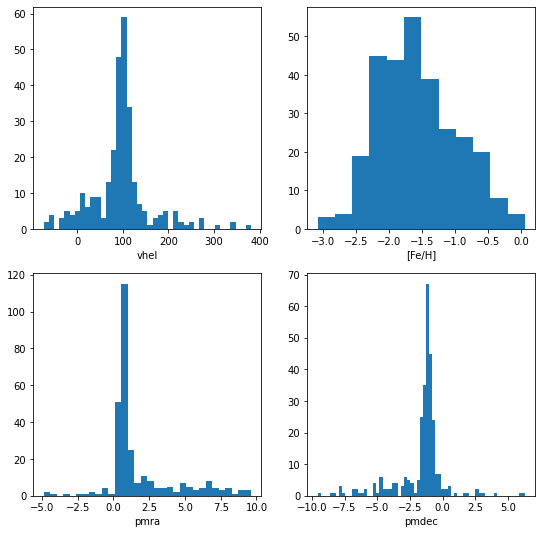

In [6]:
fig, axes = plt.subplots(2,2,figsize=(9,9))
axes[0,0].hist(rv, bins='auto');
axes[0,0].set_xlabel("vhel")
axes[0,1].hist(feh, bins='auto');
axes[0,1].set_xlabel("[Fe/H]")
axes[1,0].hist(pmra, bins='auto');
axes[1,0].set_xlabel("pmra")
axes[1,1].hist(pmdec, bins='auto');
axes[1,1].set_xlabel("pmdec")

In [7]:
N = len(tab)
# Create 2-D arrays for proper motion
pms = np.zeros((N,2)) # Return a new array of given shape (150,2)
pms[:,0] = tab["pmra"]
pms[:,1] = tab["pmdec"]
# assume uniform background
pmmax = np.max(np.sqrt(np.sum(pms**2, axis=1)))
pmnorm = 1/(np.pi * pmmax**2)
# Covariance Matrix
pmcovs = np.zeros((N,2,2))
pmcovs[:,0,0] = tab["pmra_error"]**2
pmcovs[:,1,1] = tab["pmdec_error"]**2
pmcovs[:,0,1] = tab["pmra_error"]*tab["pmdec_error"]*tab["pmra_pmdec_corr"]
pmcovs[:,1,0] = tab["pmra_error"]*tab["pmdec_error"]*tab["pmra_pmdec_corr"]

We will model the smcnod data as a mixture of 3 gaussians. The parameters will be:

* pgal = fraction of stars in the galaxy
* pbg1 = fraction of stars in the 1st background component
* pmra = Heliocentric proper motion, RA of the galaxy in mas/yr
* pmdec = Heliocentric proper motion, Dec of the galaxy in mas/yr
* vhel = mean velocity of the galaxy in km/s
* lsigv = log10 the velocity dispersion of the galaxy in km/s
* feh = mean metallicity of the galaxy in dex
* lsigfeh = log10 the metallicity dispersion of the galaxy in dex
* vbg1, lsigvbg1, fehbg1, lsigfeh1 = same parameters for 1st background component
* vbg2, lsigvbg2, fehbg2, lsigfeh2 = same parameters for 2nd background component

In total there are 16 parameters.

# Likelihood function

In [8]:
data = dict(N=len(tab), pms=pms, pmcovs=pmcovs, pmnorm=pmnorm)

In [10]:
param_labels = ["pgal","pbg1",
                "vhel","lsigv","feh","lsigfeh",
                "vbg1","lsigvbg1","fehbg1","lsigfeh1",
                "vbg2","lsigvbg2","fehbg2","lsigfeh2",
                "pmra","pmdec"]
def full_like(theta):
    """ Likelihood and Prior """
    pgal, pbg1, \
    vhel, lsigv, feh0, lsigfeh, \
    vbg1, lsigvbg1, fehbg1, lsigfeh1, \
    vbg2, lsigvbg2, fehbg2, lsigfeh2, \
    pmra_gal, pmdec_gal = theta
    
    pm0s = np.zeros((N,2))
    pm0s[:,0] = pmra_gal
    pm0s[:,1] = pmdec_gal
    
    # The prior is just a bunch of hard cutoffs
    if (pgal > 1) or (pgal < 0) or (pbg1 > 1) or (pbg1 < 0) or \
        (lsigv > 3) or (lsigvbg1 > 3) or (lsigvbg2 > 3) or \
        (lsigv < -1) or (lsigvbg1 < -1) or (lsigvbg2 < -1) or \
        (lsigfeh > 1) or (lsigfeh1 > 1) or (lsigfeh1 > 1) or \
        (lsigfeh < -3) or (lsigfeh1 < -3) or (lsigfeh1 < -3) or \
        (vhel > 400) or (vhel < -100) or (vbg1 > 500) or (vbg1 < 50) or \
        (vbg2 > 50) or (vbg2 < -50) or (abs(pmra_gal) > 2) or (abs(pmdec_gal) > 2):
        return -1e10
    
    # Compute log likelihood in rv
    lgal_vhel = stats.norm.logpdf(rv, loc=vhel, scale=np.sqrt(rverr**2 + (10**lsigv)**2))
    lbg1_vhel = stats.norm.logpdf(rv, loc=vbg1, scale=np.sqrt(rverr**2 + (10**lsigvbg1)**2))
    lbg2_vhel = stats.norm.logpdf(rv, loc=vbg2, scale=np.sqrt(rverr**2 + (10**lsigvbg2)**2))
    
    # Compute log likelihood in feh
    lgal_feh = stats.norm.logpdf(feh, loc=feh0, scale=np.sqrt(feherr**2 + (10**lsigfeh)**2))
    lbg1_feh = stats.norm.logpdf(feh, loc=fehbg1, scale=np.sqrt(feherr**2 + (10**lsigfeh1)**2))
    lbg2_feh = stats.norm.logpdf(feh, loc=fehbg2, scale=np.sqrt(feherr**2 + (10**lsigfeh2)**2))
    
    # Compute log likelihood in proper motions
    lgal_pm = [stats.multivariate_normal.logpdf(pms[i], mean=pm0s[i], cov=pmcovs[i]) for i in range(N)]
    lbg1_pm = np.log(data["pmnorm"])
    lbg2_pm = np.log(data["pmnorm"])
    
    # Combine the components
    lgal = np.log(pgal)+lgal_vhel+lgal_pm+lgal_feh
    lbg1 = np.log(pbg1)+lbg1_vhel+lbg1_pm+lbg1_feh
    lbg2 = np.log(1-pbg1)+lbg2_vhel+lbg2_pm +lbg2_feh
    lbgtot = np.logaddexp(lbg1, lbg2)
    ltot = np.logaddexp(lgal, np.log(1-pgal)+lbgtot)
    return ltot.sum()

def get_paramdict(theta):
    return OrderedDict(zip(param_labels, theta))

In [11]:
def project_model(theta, rvmin=-100, rvmax=400, fehmin=-3, fehmax=0, pmramin=-10,pmramax=50,pmdecmin=-20,pmdecmax=15):
    """ Turn parameters into rv and feh distributions """
    rvarr = np.linspace(rvmin, rvmax, 1000)
    feharr = np.linspace(fehmin, fehmax, 1000)
    #pmraarr = np.linspace(pmramin, pmramax, 1000)
    #pmdecarr = np.linspace(pmdecmin, pmdecmax, 1000)
    
    params = get_paramdict(theta)
    
    prv0 = params["pgal"]*stats.norm.pdf(rvarr, loc=params["vhel"], scale=10**params["lsigv"])
    prv1 = (1-params["pgal"])*params["pbg1"]*stats.norm.pdf(rvarr, loc=params["vbg1"], scale=10**params["lsigvbg1"])
    prv2 = (1-params["pgal"])*(1-params["pbg1"])*stats.norm.pdf(rvarr, loc=params["vbg2"], scale=10**params["lsigvbg2"])
    
    pfe0 = params["pgal"]*stats.norm.pdf(feharr, loc=params["feh"], scale=10**params["lsigfeh"])
    pfe1 = (1-params["pgal"])*params["pbg1"]*stats.norm.pdf(feharr, loc=params["fehbg1"], scale=10**params["lsigfeh1"])
    pfe2 = (1-params["pgal"])*(1-params["pbg1"])*stats.norm.pdf(feharr, loc=params["fehbg2"], scale=10**params["lsigfeh2"])
    return rvarr, prv0, prv1, prv2,feharr, pfe0, pfe1, pfe2

In [12]:
def plot_1d_distrs(theta):
    colors = list(plt.rcParams["axes.prop_cycle"].by_key()["color"])
    model_output = project_model(theta)
    fig, axes = plt.subplots(1,2,figsize=(10,5))
    
    ax = axes[0]
    ax.hist(rv, density=True, color='grey', bins=200)
    xp, p0, p1, p2 = model_output[0:4]
    ax.plot(xp, p0 + p1 + p2, 'k-', label="Total", lw=3)
    ax.plot(xp, p2, ':', color=colors[2], label="bg2", lw=3)
    ax.plot(xp, p1, ':', color=colors[1], label="bg1", lw=3)
    ax.plot(xp, p0, ':', color=colors[0], label="gal", lw=3)
    ax.set(xlabel="vhel (km/s)", ylabel="Prob. Density")
    ax.legend(fontsize='small')

    ax = axes[1]
    ax.hist(feh, density=True, color='grey', bins='auto')
    xp, p0, p1, p2 = model_output[4:8]
    ax.plot(xp, p0 + p1 + p2, 'k-', lw=3)
    ax.plot(xp, p2, ':', color=colors[2], label="bg2", lw=3)
    ax.plot(xp, p1, ':', color=colors[1], label="bg1", lw=3)
    ax.plot(xp, p0, ':', color=colors[0], label="gal", lw=3)
    ax.set(xlabel="[Fe/H] (dex)", ylabel="Prob. Density")
    return fig

In [13]:
def plot_2d_distr(theta):
    fig, ax = plt.subplots(figsize=(5,5))
    ax.plot(feh, rv, 'k.')
    ax.set(xlabel="[Fe/H] (dex)", ylabel="vhel (km/s)", xlim=(-4,1), ylim=(-100,400))
    
    params = get_paramdict(theta)
    colors = list(plt.rcParams["axes.prop_cycle"].by_key()["color"])
    ax.errorbar(params["feh"], params["vhel"],
               xerr=2*10**params["lsigfeh"], yerr=2*10**params["lsigv"],
               color=colors[0], marker='o', elinewidth=1, capsize=3, zorder=9999)
    ax.errorbar(params["fehbg1"], params["vbg1"],
               xerr=2*10**params["lsigfeh1"], yerr=2*10**params["lsigvbg1"],
               color=colors[1], marker='x', elinewidth=1, capsize=3, zorder=9999)
    ax.errorbar(params["fehbg2"], params["vbg2"],
               xerr=2*10**params["lsigfeh2"], yerr=2*10**params["lsigvbg2"],
               color=colors[2], marker='.', elinewidth=1, capsize=3, zorder=9999)

    ax.grid()

# Optimize parameters



In [14]:
## I found this guess by looking at the plot by eye and estimating. This part requires some futzing.
p0_guess = [0.47, 0.57,
            102, 1.3, -1.9,-0.5,
            140, 2.0, -1.3, -0.37,
            27, 1.6, -0.7, -0.5,
            0.7, -1.1]

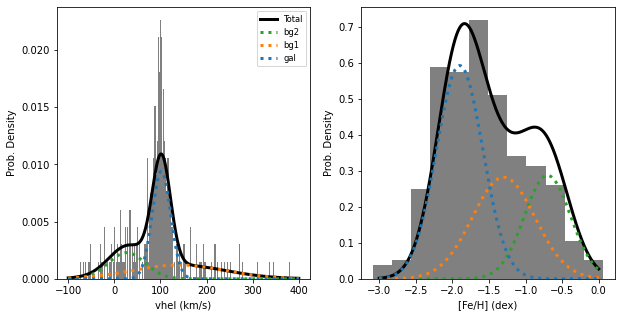

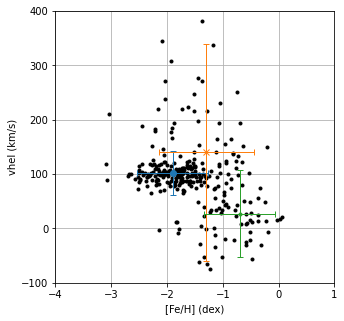

In [15]:
fig1 = plot_1d_distrs(p0_guess[:14])
fig2 = plot_2d_distr(p0_guess[:14])

In [16]:
optfunc = lambda theta: -full_like(theta)

In [17]:
%timeit optfunc(p0_guess)

19.8 ms ± 236 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [18]:
optfunc(p0_guess)

2541.4397373298043

In [19]:
%time res = optimize.minimize(optfunc, p0_guess, method="Nelder-Mead")

CPU times: user 1min 1s, sys: 198 ms, total: 1min 1s
Wall time: 1min 1s


In [20]:
res.x

array([ 5.90820019e-01,  2.08071027e-01,  1.01880477e+02,  1.32220380e+00,
       -1.87451154e+00, -5.18724777e-01,  2.25338616e+02,  1.86054881e+00,
       -1.62379525e+00, -2.63909800e-01,  4.73904429e+01,  1.77946587e+00,
       -8.94421473e-01, -3.79529787e-01,  7.04381028e-01, -1.12841343e+00])

In [21]:
optfunc(res.x)

2523.842388725263

In [22]:
for label, p in zip(param_labels, res.x):
    print(f"{label}: {p:.3f}")

pgal: 0.591
pbg1: 0.208
vhel: 101.880
lsigv: 1.322
feh: -1.875
lsigfeh: -0.519
vbg1: 225.339
lsigvbg1: 1.861
fehbg1: -1.624
lsigfeh1: -0.264
vbg2: 47.390
lsigvbg2: 1.779
fehbg2: -0.894
lsigfeh2: -0.380
pmra: 0.704
pmdec: -1.128


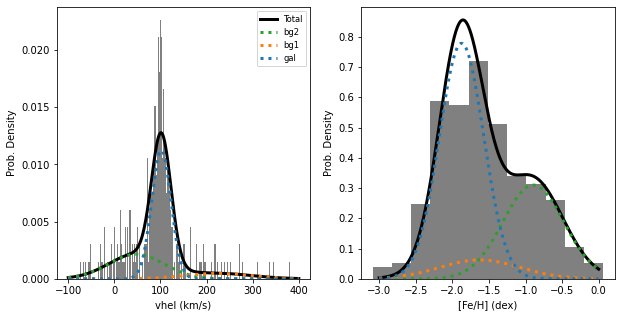

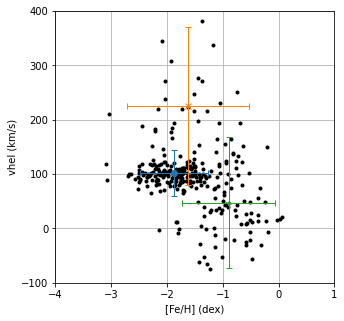

In [23]:
fig1 = plot_1d_distrs(res.x[:14])
fig2 = plot_2d_distr(res.x[:14])

## Posterior Sampling
The posterior is sampled using `emcee` with 64 walkers and 10,000 steps per chain.

In [24]:
nw = 64
p0 = res['x']
nit = 2000
ep0 = np.zeros(len(p0_guess)) + 0.02
p0s = np.random.multivariate_normal(p0_guess, np.diag(ep0)**2, size=nw)
print(p0s)

[[  0.45655962   0.56727439 102.03969627 ...  -0.52642139   0.71042535
   -1.12889889]
 [  0.49132725   0.57587489 102.00324884 ...  -0.48403952   0.67753051
   -1.14754893]
 [  0.48197396   0.56956375 102.01839981 ...  -0.49430808   0.69234689
   -1.10764191]
 ...
 [  0.49892498   0.57290553 102.03867665 ...  -0.49753909   0.70287637
   -1.08190702]
 [  0.43890926   0.58092339 102.00811439 ...  -0.5217213    0.67105852
   -1.11047688]
 [  0.44400874   0.59290063 101.93825597 ...  -0.50753135   0.64258512
   -1.10532849]]


In [25]:
nparams = len(param_labels)
print(nparams)
nwalkers = 64
p0 = p0_guess
ep0 = np.zeros(len(p0)) + 0.02 # some arbitrary width that's pretty close; scale accordingly to your expectation of the uncertainty
p0s = np.random.multivariate_normal(p0, np.diag(ep0)**2, size=nwalkers)
## Check to see things are initialized ok
lkhds = [full_like(p0s[j]) for j in range(nwalkers)]
assert np.all(np.array(lkhds) > -9e9)

16


In [26]:
def get_rstate():
    return np.random.mtrand.RandomState(seed=np.random.randint(0,2**32-1))
#from schwimmbad import MultiPool
#pool = MultiPool(4)
es = emcee.EnsembleSampler(
    nw, len(p0_guess), full_like)

In [27]:
%time PP = es.run_mcmc(p0s, nit, rstate0=get_rstate())
es.reset()

CPU times: user 38min 1s, sys: 8.27 s, total: 38min 9s
Wall time: 38min 7s


In [28]:
%time es.run_mcmc(PP.coords, nit, rstate0=get_rstate())
np.save("results_smcnod.npy",es.flatchain)

CPU times: user 36min 35s, sys: 8.09 s, total: 36min 43s
Wall time: 36min 40s


In [41]:
outputs = es.flatchain

### Acceptance fraction
Judging the convergence and performance of an algorithm is a non-trival problem. As a rule of thumb, the acceptance fraction should be between 0.2 and 0.5 (for example, Gelman, Roberts, & Gilks 1996).

In [62]:
# Another good test of whether or not the sampling went well is to 
# check the mean acceptance fraction of the ensemble
print(
    "Mean acceptance fraction: {0:.3f}".format(
        np.mean(es.acceptance_fraction)
    )
)

Mean acceptance fraction: 0.316


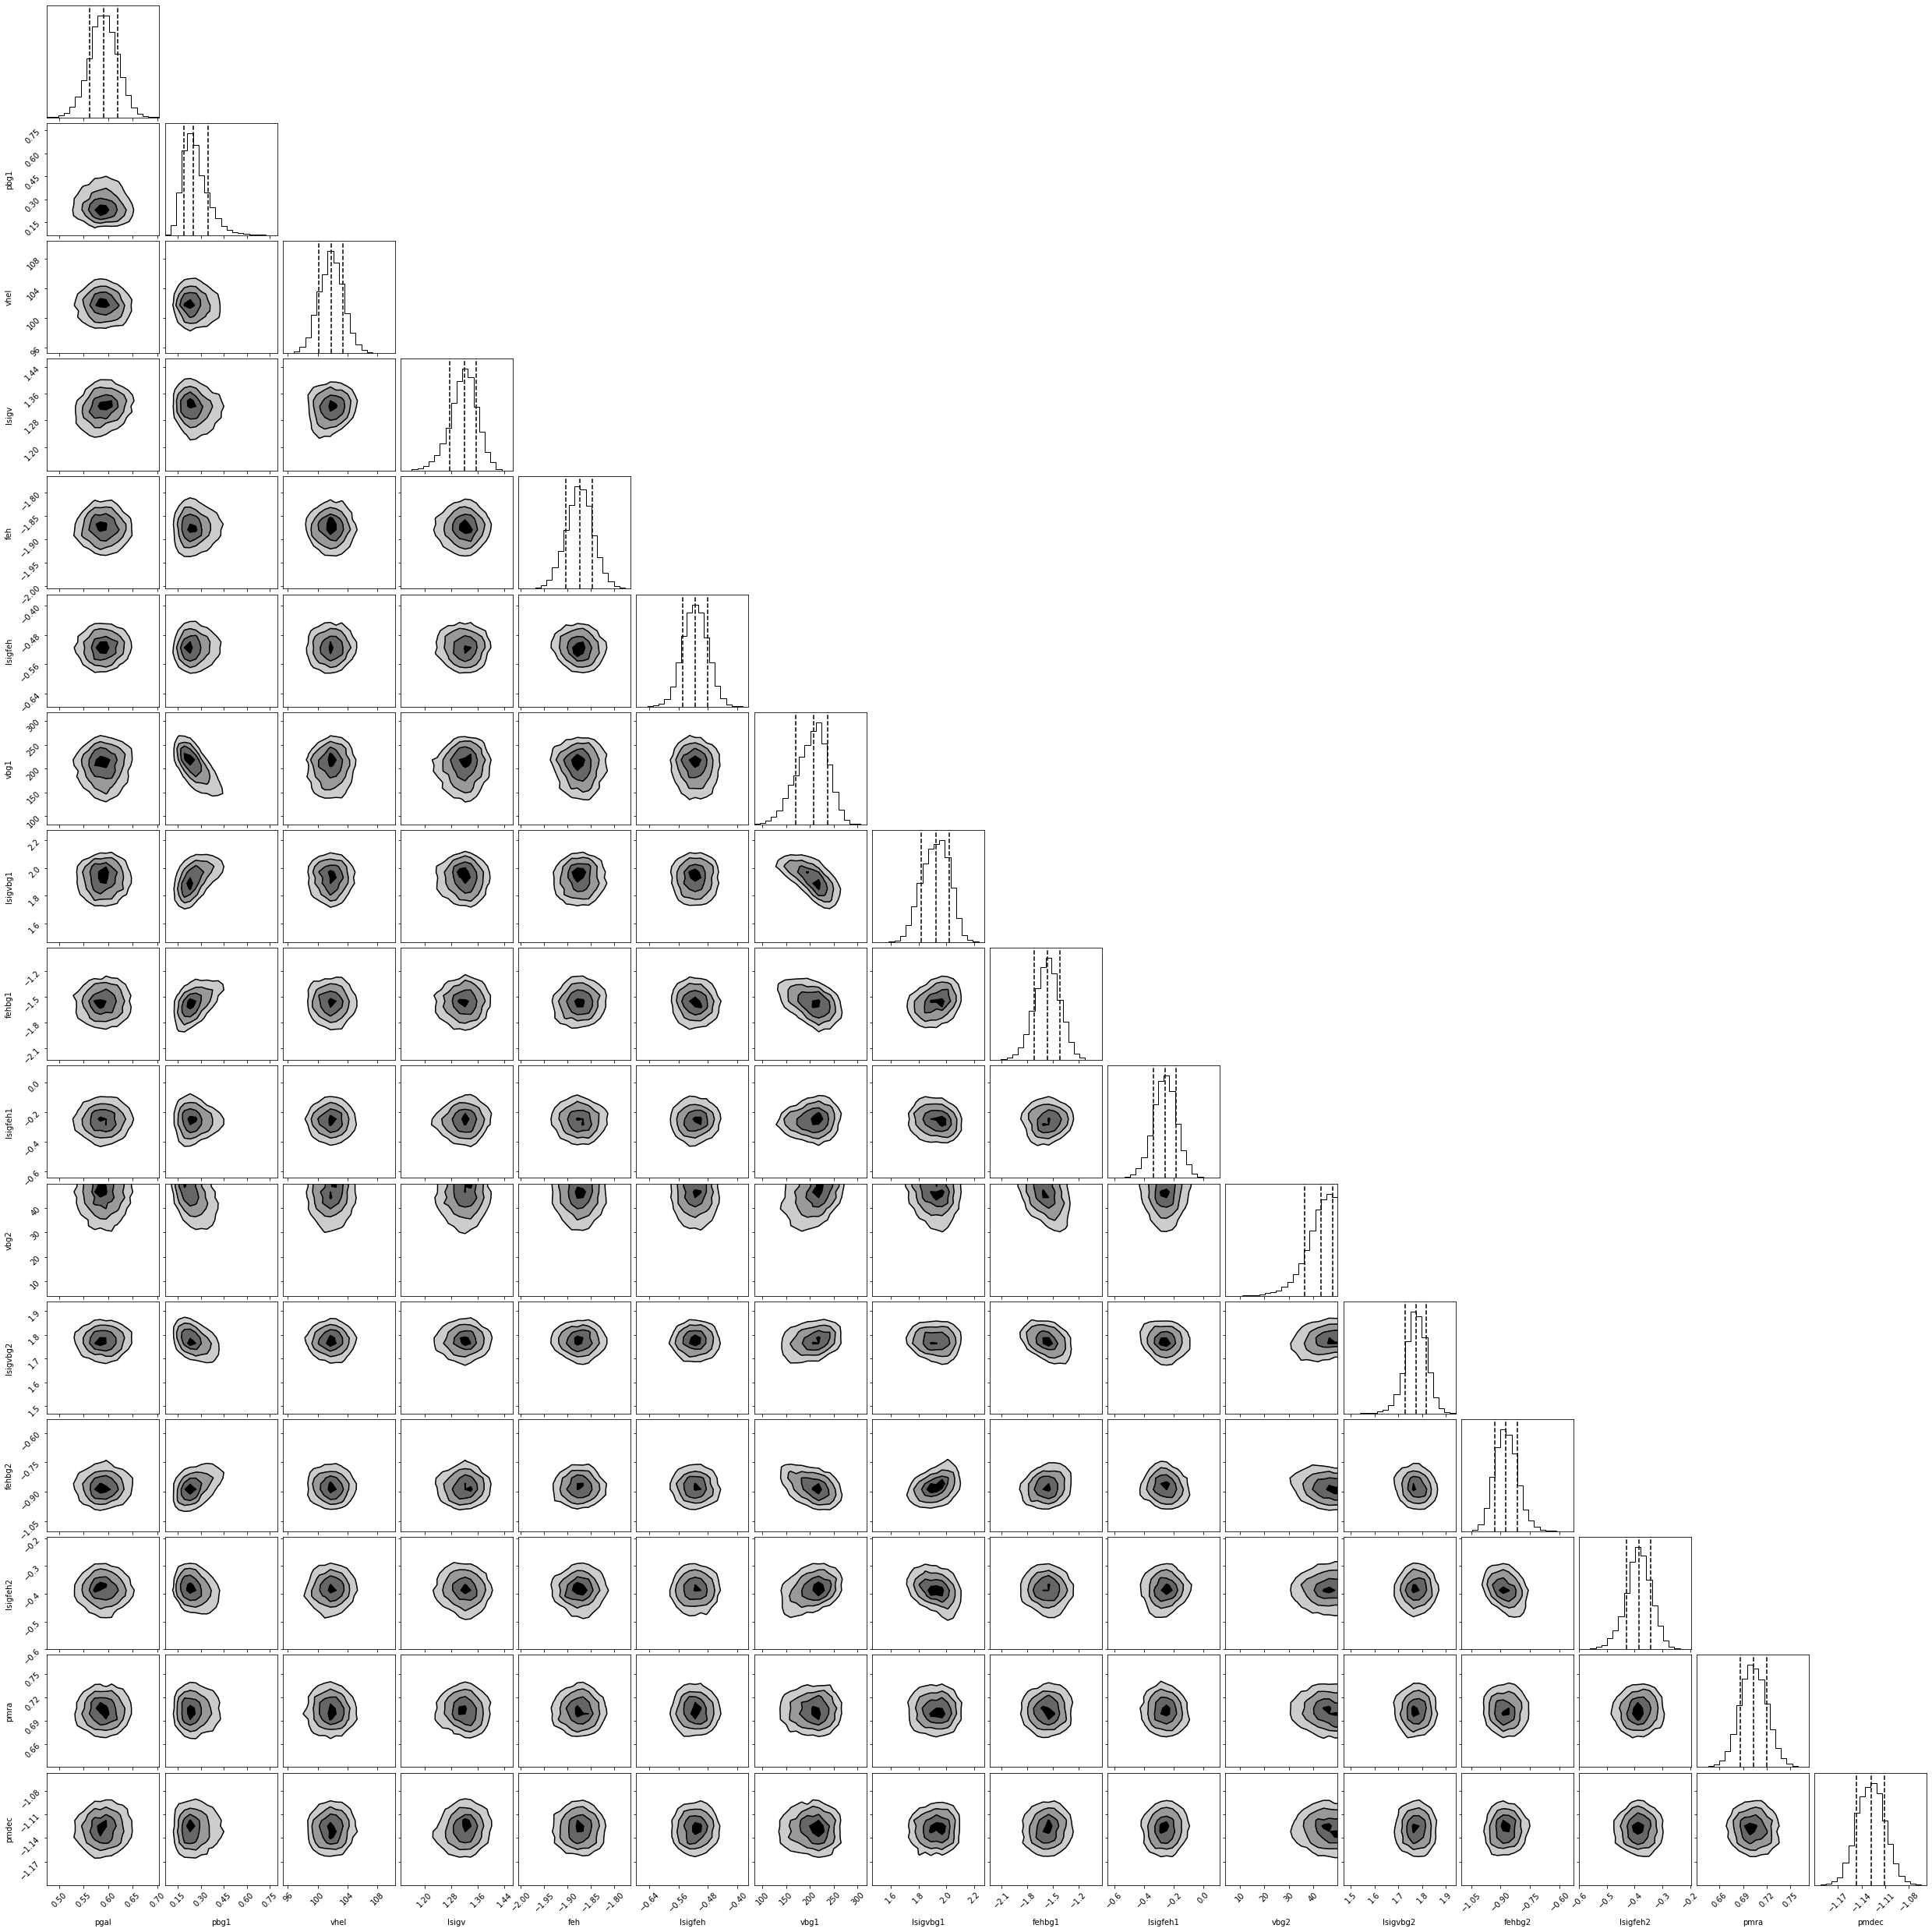

In [42]:
fig = corner.corner(outputs, labels=param_labels, quantiles=[0.16,0.50,0.84],color='black', # add some colors
              **{'plot_datapoints': False, 'fill_contours': True})
plt.savefig('SMCNOD_PM_Model_Cornerplot.png')

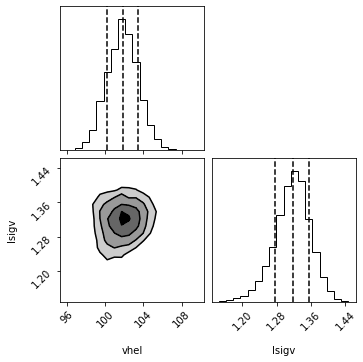

In [43]:
fig1 = corner.corner(outputs[:,2:4], labels=param_labels[2:4], quantiles=[0.16,0.50,0.84],color='black', # add some colors
              **{'plot_datapoints': False, 'fill_contours': True})

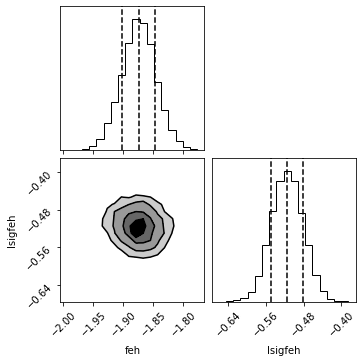

In [45]:
fig2 = corner.corner(outputs[:,4:6], labels=param_labels[4:6], quantiles=[0.16,0.50,0.84],color='black', # add some colors
              **{'plot_datapoints': False, 'fill_contours': True})

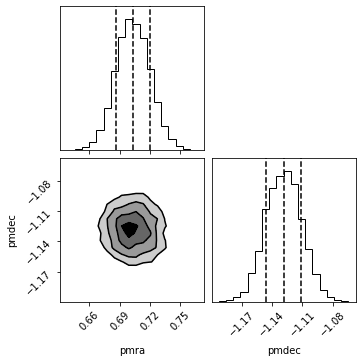

In [44]:
fig3 = corner.corner(outputs[:,14:16], labels=param_labels[14:16], quantiles=[0.16,0.50,0.84],color='black', # add some colors
              **{'plot_datapoints': False, 'fill_contours': True})

In [49]:
def process_chain(chain, avg_error=True):
    pctl = np.percentile(chain, [16, 50, 84], axis=0)
    meds = pctl[1]
    ep = pctl[2]-pctl[1]
    em = pctl[0]-pctl[1]
    if avg_error: # just for simplicity, assuming no asymmetry
        err = (ep-em)/2
        return OrderedDict(zip(param_labels, meds)), OrderedDict(zip(param_labels, err))
    else:
        return OrderedDict(zip(param_labels, meds)), OrderedDict(zip(param_labels, ep)), OrderedDict(zip(param_labels, em))

In [50]:
meds, errs = process_chain(outputs)

In [51]:
for k,v in meds.items():
    print("{} {:.3f} {:.3f}".format(k, v, errs[k]))

pgal 0.590 0.028
pbg1 0.252 0.079
vhel 101.836 1.637
lsigv 1.319 0.040
feh -1.874 0.028
lsigfeh -0.515 0.034
vbg1 207.223 33.579
lsigvbg1 1.927 0.101
fehbg1 -1.564 0.150
lsigfeh1 -0.259 0.076
vbg2 43.238 5.706
lsigvbg2 1.774 0.044
fehbg2 -0.874 0.057
lsigfeh2 -0.385 0.045
pmra 0.703 0.017
pmdec -1.128 0.018


If things are well mixed, then you can just use the flat chain to concatenate all the walkers and steps.
The results here may not be perfectly mixed, but it's not terrible.
There are fancy ways to check things here involving autocorrelation times that Alex does not know about.
To me this is the hard part of emcee: knowing when you're happy with the result, and setting things up so that it gets there as fast as possible. This is why I prefer dynesty, even though it's slower it has a motivated stopping condition.

In [53]:
chain = es.flatchain
chain.shape

(128000, 16)

You can see the output of the fit as a corner plot. Basically you want everything to be nice and round, and if not that means you didn't initialize your walkers well enough or burn in for long enough.

It's customary to summarize the data with percentiles, but you should check the corner plot diagonal to see if this is a good idea.

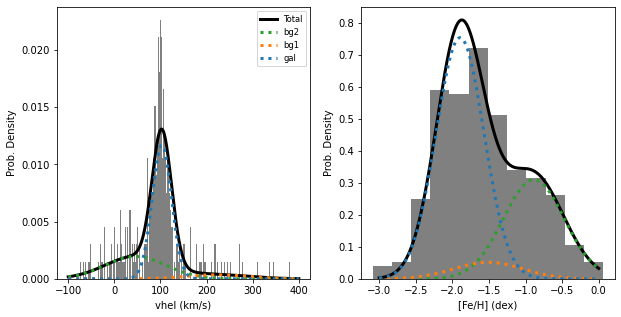

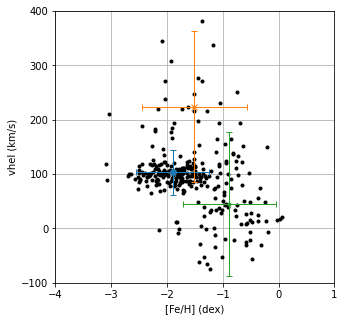

In [54]:
fig1 = plot_1d_distrs(chain[1])
fig2 = plot_2d_distr(chain[1])

In [56]:
10**meds["lsigfeh"]

0.30547979432492317

In [57]:
10**meds["lsigv"]

20.83873908187928

In [58]:
mean_vdisp = np.percentile(chain_new, 50)
mean_vdisp

3.352627728541213

In [67]:
chain_new = 10**chain
mean_vdisp = np.percentile(chain_new[:,3], 50)
std_vdisp = (np.percentile(chain_new[:,3], 84)-np.percentile(chain_new[:,3], 16))/2
mean_fehdisp = np.percentile(chain_new[:,5], 50)
std_fehdisp = (np.percentile(chain_new[:,5], 84)-np.percentile(chain_new[:,5], 16))/2
print("mean_vdisp: ",mean_vdisp, \
     "std_vdisp: ",std_vdisp)
print("mean_fehdisp: ",mean_fehdisp, \
     "std_fehdisp: ",std_fehdisp)

mean_vdisp:  20.83873908187928 std_vdisp:  1.9026695786111976
mean_fehdisp:  0.30547979432492345 std_fehdisp:  0.023793356263873078


/var/folders/9w/8jsv_f1j1t357nbjlwl197kr0000gn/T/ipykernel_35590/101134085.py:1: RuntimeWarning: overflow encountered in power
  chain_new = 10**chain


In [60]:
param_labels_1 = ["pgal = ","pbg1 = ",
                "vhel = ","lsigv = ","feh = ","lsigfeh = ",
                "vbg1 = ","lsigvbg1 = ","fehbg1 = ","lsigfeh1 = ",
                "vbg2 = ","lsigvbg2 = ","fehbg2 = ","lsigfeh2 = ",
                "pmra = ","pmdec = "]
def process_chain_1(chain, avg_error=True):
    pctl = np.percentile(chain, [16, 50, 84], axis=0)
    median = pctl[1]
    ep = pctl[2]-pctl[1]
    em = pctl[0]-pctl[1]
    if avg_error:
        err = (ep-em)/2
        return OrderedDict(zip(param_labels_1, median)), OrderedDict(zip(param_labels_1, err))
    else:
        return OrderedDict(zip(param_labels_1, median)), OrderedDict(zip(param_labels_1, ep)), OrderedDict(zip(param_labels_1, em))

meds_1, errs_1 = process_chain_1(outputs)

for k,v in meds_1.items():
    print("{} {:.3f}".format(k, v))

pgal =  0.590
pbg1 =  0.252
vhel =  101.836
lsigv =  1.319
feh =  -1.874
lsigfeh =  -0.515
vbg1 =  207.223
lsigvbg1 =  1.927
fehbg1 =  -1.564
lsigfeh1 =  -0.259
vbg2 =  43.238
lsigvbg2 =  1.774
fehbg2 =  -0.874
lsigfeh2 =  -0.385
pmra =  0.703
pmdec =  -1.128
